##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)


In [2]:
import numpy as np
from importlib import reload

# Importing my modules
from src.main import (
    geometry_operations,
    optimization_compute_quantification,
    classes_linear_optimization,
)

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (None)/charset_normalizer (2.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
# %store -r line_gdf_reworked
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf
# %store -r line_gdf_v1
%store -r slope_line
%store -r results_df 
%store -r line_gdf_19_10_2023
#rewrite this if the result of the main optimization changed

line_gdf = line_gdf_19_10_2023.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)


In [4]:
bhd_series = harvesteable_trees_gdf["BHD"]
height_series = harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)

# Prepare the gdfs
uphill_yarding = True
line_gdf["line_cost"] = optimization_compute_quantification.compute_line_costs(
    line_gdf, uphill_yarding, large_yarder=True
)
harvesteable_trees_gdf[
    "cubic_volume"
] = optimization_compute_quantification.compute_tree_volume(bhd_series, height_series)

In [5]:
# line_gdf = line_gdf.iloc[0:10]
# harvesteable_trees_gdf = harvesteable_trees_gdf.iloc[0:100]

#### Clustering Trees for Sortiment


In [6]:
from sklearn.cluster import KMeans

n_clusters = len(harvesteable_trees_gdf) // 20
k_means = KMeans(n_clusters=n_clusters)
y = k_means.fit_predict(
    X=[*zip(harvesteable_trees_gdf["x"], harvesteable_trees_gdf["y"])]
)

In [7]:
import plotly.express as px

fig = px.scatter()
fig.add_scatter(
    x=harvesteable_trees_gdf["x"],
    y=harvesteable_trees_gdf["y"],
    mode="markers",
    marker=dict(color=y),
)

fig.show()

Der A-Wert ist prinzipiell nicht auf eine Baumart beschränkt, bislang wurde er jedoch von uns nur in Fichtenbeständen angewandt. Er ist zum einen vom H/D-Wert (Höhe zu Durchmesser) des Z-Baumes und zum anderen vom Durchmesser und dem Abstand des jeweiligen Nachbarbaumes abhängig. Bei der Entwicklung des A-Wertes ging Johann von folgenden, jedem Forstmann bekannten Überlegungen aus:

    Der Standraumbedarf eines Z-Stammes ist umso größer, je höher er ist. Ein Nachbarbaum wird zum Konkurrenten (K), indem er in den Standraum des Z-Stammes (Z) eindringt. Ist die Höhe des Konkurrenten gleich wie die Höhe (H) des Z-Baumes, d.h. von gleicher sozialer Stel-lung, so steigt der Konkurrenzdruck mit zunehmender Baumhöhe und abnehmen-der Entfernung (E) zwischen den beiden: H/E
    Ein niedriger bzw. (sozial) schwächerer Baum wird auf den Z-Stamm vergleichsweise einen geringeren Konkurrenzdruck ausüben als ein stärkerer. Dieser Sachverhalt lässt sich auch als Verhältnis der Durchmesser von Konkurrent (d) zu Z-Stamm (D) darstellen: d/D

Beide Überlegungen zusammengefasst ergeben die Formel für den A-Wert eines Nachbarbaumes des Z-Stammes:
A=H/E \* d/D

Bei der Freistellung nach A-Wert wird ein Konkurrent immer dann entnommen, wenn seine Entfernung zum Z-Baum eine bestimmte Grenzdistanz (GD) – bei festgelegtem A-Wert - unterschreitet:
GD < H/A\*d/D

In der Abbildung 1 ist der Zusammenhang zwischen H/D-Wert des Z-Baumes, BHD des Konkurrenten und Grenzdistanz dargestellt. Beispielsweise beträgt für einen Z-Stamm mit H/D-Wert 80 und einem festgelegten A-Wert von 4 bzw. 6 die Grenz-distanz eines Konkurrenten mit 30 cm BHD 6 m bzw. 4 m; bei einem H/D-Wert von 100 betragen die Grenzdistanzen 7,5 m bzw. 5 m.


In [8]:
harvesteable_trees_gdf["h"] = (
    harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)
)

In [9]:
harvesteable_trees_gdf["H/D_value"] = (
    harvesteable_trees_gdf["h"] / harvesteable_trees_gdf["BHD"]
)

indexes_to_keep = []
A_value = 5

# doing this too many times
for cluster in range(n_clusters):
    # select trees
    index = np.where(y == cluster)
    sub_df = harvesteable_trees_gdf.iloc[index]

    # determine index of largest tree
    z_tree_index = sub_df["BHD"].idxmax()
    z_tree = sub_df.loc[z_tree_index]
    z_tree_bhd = z_tree["BHD"]
    z_tree_h = z_tree["h"]

    # compute the distance of all trees to the largest tree
    sub_df["distance_to_z_tree"] = sub_df.distance(sub_df.loc[z_tree_index].geometry)

    # drop the largest tree from the dataframe so we dont fell it
    sub_df.drop(z_tree_index, inplace=True)

    # # A=H/E * d/D
    # sub_df["A_value"] = (z_tree_h / sub_df["distance_to_z_tree"]) * (
    #     sub_df["BHD"] / z_tree_bhd
    # )

    # select those trees which are too close to the z tree with GD < H/A*d/D
    # negate the condition, since those are the trees we keep. The trees in the list will be felled
    sub_df = sub_df[
        ~(
            sub_df["distance_to_z_tree"]
            < (z_tree_h / A_value) * (sub_df["BHD"] / z_tree_bhd)
        )
    ]

    # add the indexes to fell to the list
    indexes_to_keep.extend(sub_df.index)

harvesteable_trees_gdf_sortiment = harvesteable_trees_gdf.loc[indexes_to_keep]

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_376063/3571965119.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [10]:
print(
    "went from ",
    len(harvesteable_trees_gdf),
    " to ",
    len(harvesteable_trees_gdf_sortiment),
    " trees",
)

went from  516  to  464  trees


In [11]:
# line_gdf = line_gdf.sample(70)
# harvesteable_trees_gdf = harvesteable_trees_gdf.sample(500)

#### <a id='toc1_1_1_3_'></a>[Single-Objective](#toc0_)


In [12]:
%%time

reload(optimization_compute_quantification)
reload(classes_linear_optimization)

# Lists to store the results
optimization_result_list = []
lscp_model_list = []

for i in range(0, 3):
    print(f"Starting with objective {i}")
    # set up the model with firs the monetary objective (0), then sideways slope (1) and steep segments (2) as single objective
    lscp_optimization = classes_linear_optimization.optimization_object_spopt(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        objective_to_select=i,
        maximum_nuber_cable_roads=5,
    )
    lscp_optimization.add_generic_vars_and_constraints()
    lscp_optimization.add_single_objective_function()
    # and solve it
    # %lprun -T tmp0.txt -f lscp_optimization.solve lscp_optimization.solve()
    lscp_optimization.solve()
    lscp_model_list.append(lscp_optimization)

Starting with objective 0
test
Starting with objective 1
test
Starting with objective 2
test
CPU times: user 4.72 s, sys: 36.9 ms, total: 4.76 s
Wall time: 26.4 s


In [13]:
reload(classes_linear_optimization)
for count, optimization_object in enumerate(lscp_model_list):
    optimization_result_list.append(
        classes_linear_optimization.spopt_result(
            optimization_object,
            line_gdf,
            optimization_object.name + str(count),
        )
    )

In [14]:
%%time
# SOO manual weights
lscp_optimization = classes_linear_optimization.optimization_object_spopt(
    "Single Objective",
    line_gdf,
    harvesteable_trees_gdf,
    height_gdf,
    objective_to_select=i,
    maximum_nuber_cable_roads=4,
)
lscp_optimization.add_generic_vars_and_constraints()
# lscp_optimization.add_single_objective_function()
lscp_optimization.model.problem += lscp_optimization.add_cost_objective()
lscp_optimization.model.problem += lscp_optimization.add_ecological_objective() / 2
lscp_optimization.model.problem += lscp_optimization.add_ergonomic_objective() / 2
# and solve it
# %lprun -T tmp0.txt -f lscp_optimization.solve lscp_optimization.solve()
lscp_optimization.solve()
lscp_model_list.append(lscp_optimization)

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



test
CPU times: user 3.27 s, sys: 24.4 ms, total: 3.3 s
Wall time: 8.44 s


In [15]:
optimization_result_list.append(
    classes_linear_optimization.spopt_result(
        lscp_model_list[-1],
        line_gdf,
        lscp_model_list[-1].name + str(count),
    )
)

Profit baseline is 59903.05061245629


<AxesSubplot:>

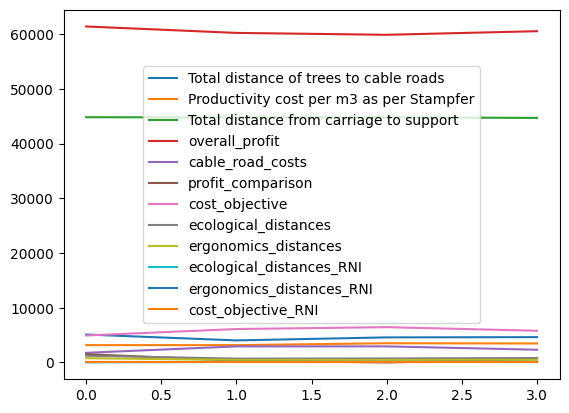

In [16]:
reload(classes_linear_optimization)

tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]

results_df = classes_linear_optimization.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.distance_tree_line,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
)

results_df.plot()

#### <a id='toc1_1_1_4_'></a>[NSGA 2](#toc0_)


In [17]:
%%time

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from src.main import classes_mo_optimization

reload(classes_mo_optimization)

cost_matrix = lscp_model_list[0].distance_tree_line
nsga_problem = classes_mo_optimization.optimization_object_pymoo(
    cost_matrix,
    lscp_model_list[0].productivity_cost,
    lscp_model_list[0].facility_cost,
    lscp_model_list[0].ecological_penalty_lateral_distances,
    lscp_model_list[0].ergonomic_penalty_lateral_distances,
)
termination = get_termination("n_gen", 50)


client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=20,
    sampling=classes_mo_optimization.CustomSampling(),  # initally zero matrix, nothing assigned
    mutation=classes_mo_optimization.MyMutation(),
    repair=classes_mo_optimization.MyRepair(),
    crossover=classes_mo_optimization.CustomCrossOver(),  # crossover: take the sum of CRs from both and then randomly pick the same amount from both
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(
    nsga_problem,
    algorithm,
    termination,
    verbose=True,
    return_least_infeasible=True,
    seed=0,
)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/src/main/classes_mo_optimization.py:425: RuntimeWarning:

overflow encountered in exp



     2 |       21 |      2 |  0.000000E+00 |  0.000000E+00 |  2.440394E+02 |         ideal
     3 |       41 |      8 |  0.000000E+00 |  0.000000E+00 |  0.6358170431 |         ideal
     4 |       61 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1042366896 |         ideal
     5 |       81 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0552283203 |         ideal
     6 |      101 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0137234672 |         nadir
     7 |      121 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0244061239 |             f
     8 |      141 |     19 |  0.000000E+00 |  0.000000E+00 |  0.2072632032 |         ideal
     9 |      161 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0115963553 |             f
    10 |      181 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0434508520 |             f
    11 |      201 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0943875784 |         ideal
    12 |      221 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0747364172 |             f

In [18]:
reload(classes_mo_optimization)
len_x = len(res.X)
# optimization_result_list = []
# samples = 10
# get the five best solutions
samples = np.argsort(np.sum(F, axis=1))[:5]
for i in samples:  # np.linspace(0, len_x - 1, samples).astype(int):
    optimization_result_list.append(
        classes_mo_optimization.pymoo_result(
            res.problem,
            res.X[i],
            line_gdf,
            client_range,
            facility_range,
            "NSGA2 " + str(i),
        )
    )

Profit baseline is 59903.05061245629


<AxesSubplot:>

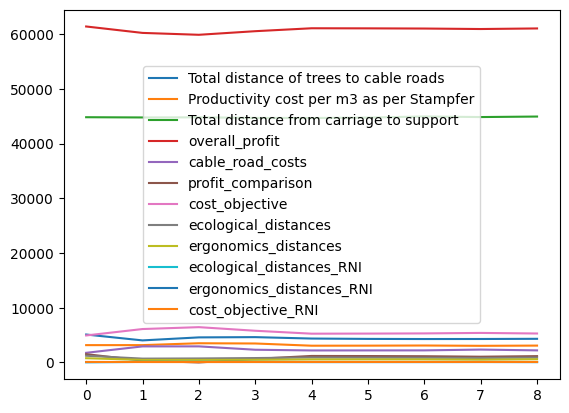

In [19]:
reload(classes_linear_optimization)

tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]

results_df = classes_linear_optimization.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.distance_tree_line,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
)

results_df.plot()

### AUGMECON MOO


#### Creating the reference table for AUGMECON approach


In [18]:
# determine the ranges of the objectives and divide them in 10 equal parts
ecological_true_max = results_df["ecological_distances"].max()
ecological_true_min = results_df["ecological_distances"].min() + 1
# ecological_true_min = 120
ergonomics_true_max = results_df["ergonomics_distances"].max()
ergonomics_true_min = results_df["ergonomics_distances"].min() + 1
# ergonomics_true_min = 63

# first determine the ranges of the objectives
max_overall_profit = results_df["overall_profit"].max()
min_overall_profit = results_df["overall_profit"].min() + 1

grid_points = 5
# create a grid of points to evaluate the objective functions
profit_range = np.linspace(min_overall_profit, max_overall_profit, grid_points)

ecological_range, ecological_step = np.linspace(
    ecological_true_max,
    ecological_true_min,
    grid_points,
    retstep=True,
)

ergonomics_range, ergonomics_step = np.linspace(
    ergonomics_true_max, ergonomics_true_min, grid_points, retstep=True
)

In [19]:
%%time

from itertools import islice

reload(classes_linear_optimization)
# line_gdf = line_gdf.iloc[0:5]
# harvesteable_trees_gdf = harvesteable_trees_gdf.iloc[0:20]
pareto_optimal_objective_values = [0]
pareto_optimal_objects = []


def augmecon():
    initial_model = classes_linear_optimization.optimization_object_spopt(
        "Single Objective",
        line_gdf,
        harvesteable_trees_gdf,
        height_gdf,
        objective_to_select=0,
    )

    initial_model.add_generic_vars_and_constraints()
    # add the main monetary objective
    initial_model.add_single_objective_function()
    initial_model.solve()

    # set up the ranges at iteration objects so we can skip steps in the loop
    i_range = iter(ecological_range)
    for i in i_range:
        print("i should be :", i)
        initial_model.add_epsilon_constraint(
            target_value=i,
            constraint_to_select="eco_constraint",
            distances_to_use=initial_model.ecological_penalty_lateral_distances,
        )

        try:
            initial_model.remove_epsilon_constraint("ergo_constraint")
        except:
            # if the constraint doesnt exist, we pass
            pass

        try:
            initial_model.solve()
        except:
            print("couldnt solve with i ", i)
            break

        (
            cost_objective,
            ecological_objective,
            ergonomics_objective,
        ) = initial_model.get_objective_values()
        print("i is :", ecological_objective)

        #
        # # determine the slack variable of the ecological constraint - this is the value of the objective function minus the expected value as per the ecological range
        # i_slack = ecological_objective - i
        # print("i is :", ecological_objective)

        j_range = iter(ergonomics_range)
        # loop through the inner objective
        for j in j_range:
            print("          j should be:", j)
            initial_model.add_epsilon_constraint(
                target_value=j,
                constraint_to_select="ergo_constraint",
                distances_to_use=initial_model.ergonomic_penalty_lateral_distances,
            )

            try:
                initial_model.solve()
            except:
                print("couldnt solve with j ", j)
                break

            (
                cost_objective,
                ecological_objective,
                ergonomics_objective,
            ) = initial_model.get_objective_values()
            i_slack = ecological_objective - i
            # determine the slack variable of the ergonomics constraint - this is the value of the objective function minus the expected value as per the ergonomics range
            j_slack = ergonomics_objective - j
            print("          j is : ", ergonomics_objective)
            print("          cost is :", cost_objective)

            ecological_index = np.where(ecological_range == i)[0][0]
            ergonomics_index = np.where(ergonomics_range == j)[0][0]
            result = classes_linear_optimization.spopt_result(
                initial_model,
                line_gdf,
                "Augmecon" + str(ecological_index) + str(ergonomics_index),
            )

            # pareto_optimal_objective_values.append(overall_objective)
            pareto_optimal_objects.append(result)

            (
                cost_objective,
                ecological_objective,
                ergonomics_objective,
            ) = initial_model.get_objective_values()

            # set the new objective
            initial_model.add_epsilon_objective(
                i_slack, j_slack, ecological_range, ergonomics_range
            )

            surface_plot_data_x.append(cost_objective)
            surface_plot_data_y.append(ecological_objective)
            surface_plot_data_z.append(ergonomics_objective)

            if j_slack > 0:
                print("couldnt improve objective?")
                break  # skipping the rest of the ergonomics range since we cant improve the objective anymore
            else:
                # the expected value as per the ergonomics range. If the slack variable is greater than what we would constrain for the next step, we skip those iterations
                j_bypass = int(abs(np.floor(j_slack / ergonomics_step)))
                if j_bypass > 0:
                    # for iterator j, skip j_bypass steps
                    print("         skipping j_bypass:", j_bypass)
                    next(islice(j_range, j_bypass, j_bypass), None)


surface_plot_data_x = []
surface_plot_data_y = []
surface_plot_data_z = []
augmecon()

test
i should be : 1231.267346761515
test
i is : 966.6163057821582
          j should be: 780.3848633390048
test
          j is :  585.7271924932948
          cost is : 5264.5723583249


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 2
          j should be: 548.5287744462652
test
          j is :  517.3351375325634
          cost is : 5392.546206695275


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



          j should be: 471.2434114820186
test
          j is :  470.2434114820186
          cost is : 5799.883283247367


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



i should be : 1099.7645988730364
test
i is : 1040.1339742127034
          j should be: 780.3848633390048
test
          j is :  621.0888349403664
          cost is : 5318.14401298344


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 2
          j should be: 548.5287744462652
test
          j is :  517.3351375325634
          cost is : 5392.546206695275


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



          j should be: 471.2434114820186
test
          j is :  470.2434114820186
          cost is : 5799.883283247367


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



i should be : 968.2618509845578
test
i is : 709.1467511358331
          j should be: 780.3848633390048
test
          j is :  560.7540231503021
          cost is : 5254.572704444807


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 2
          j should be: 548.5287744462652
test
          j is :  517.3351375325634
          cost is : 5392.546206695275


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



          j should be: 471.2434114820186
test
          j is :  470.2434114820186
          cost is : 5799.883283247367


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



i should be : 836.7591030960791
test
i is : 826.4614131222446
          j should be: 780.3848633390048
test
          j is :  517.3351375325634
          cost is : 5398.260552731473


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



         skipping j_bypass: 3
          j should be: 471.2434114820186
test
          j is :  470.2434114820186
          cost is : 5799.883283247367


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



i should be : 705.2563552076006
test
i is : 705.0819508335196
          j should be: 780.3848633390048
test
          j is :  470.2434114820186
          cost is : 5832.63470037554
         skipping j_bypass: 4
CPU times: user 52.7 s, sys: 886 ms, total: 53.6 s
Wall time: 6min 52s


/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pulp/pulp.py:1704: UserWarning:

Overwriting previously set objective.



In [20]:
optimization_result_list = optimization_result_list + pareto_optimal_objects

#### Expert Layout


In [21]:
reload(classes_linear_optimization)
selected_lines = [[30, 37], [32, 59, 71]]

for config in selected_lines:
    expert_result_1 = classes_linear_optimization.expert_result(
        indices=config,
        name="expert_layout_" + str(config),
        line_gdf=line_gdf,
        harvesteable_trees_gdf=harvesteable_trees_gdf,
        sample_productivity_cost_matrix=lscp_model_list[0].productivity_cost,
        ecological_penalty_lateral_distances=lscp_model_list[
            0
        ].ecological_penalty_lateral_distances,
        ergonomics_penalty_lateral_distances=lscp_model_list[
            0
        ].ergonomic_penalty_lateral_distances,
    )

    optimization_result_list.append(expert_result_1)

#### Comparison of Optimization Results


In [67]:
reload(classes_linear_optimization)

tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
(
    distance_tree_line,
    distance_carriage_support,
) = geometry_operations.compute_distances_facilities_clients(
    harvesteable_trees_gdf, line_gdf
)
sample_model = lscp_model_list[0]

results_df = classes_linear_optimization.model_results_comparison(
    optimization_result_list,
    line_gdf,
    sample_model.distance_tree_line,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
)

# results_df[results_df.columns[:6]] = results_df[results_df.columns[:6]].astype(int)
# results_df[results_df.columns[7:]] = results_df[results_df.columns[7:]].astype(int)
# results_df = results_df.reindex(
#     columns=[
#         "name",
#         "Productivity cost per m3 as per Stampfer",
#         "overall_profit",
#         "profit_comparison",
#         "cable_road_costs",
#         "Total distance from carriage to support",
#         "Total distance of trees to cable roads",
#         "ecological_distances",
#         "ergonomics_distances",
#     ]
# )
# results_df.set_index("name", inplace=True)

Profit baseline is 57990.972493274625


In [68]:
display(results_df)

,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,cost_objective,ecological_distances,ergonomics_distances,ecological_distances_RNI,ergonomics_distances_RNI,cost_objective_RNI
0,5110.615295,3170.829257,44835.449479,61422.927257,1766.564990,3431.954764,model0,4937.394247,1231.267347,780.384863,57,60,100
1,4035.477914,3173.157428,44791.350003,60247.517159,2939.646917,2256.544666,model1,6112.804345,704.256355,470.243411,100,100,80
2,4586.985480,3513.456273,44816.009583,59903.050612,2943.814619,1912.078119,model2,6457.270892,735.374609,470.243411,95,100,76
3,4632.428316,3471.303308,44709.991197,60561.432600,2327.585597,2570.460106,model2,5798.888904,808.272015,486.835568,87,96,85
4,4374.602501,3066.146851,44687.836702,61095.951349,2198.223304,3104.978855,NSGA2 5,5264.370155,913.019832,560.754023,77,83,93
5,4308.887986,3075.418656,44767.343966,61079.284925,2205.617923,3088.312432,NSGA2 3,5281.036579,892.092887,571.264720,78,82,93
6,4284.683290,3102.712327,44966.744819,61045.938013,2211.671164,3054.965520,NSGA2 1,5314.383491,864.987791,565.364754,81,83,92
7,4292.512876,3045.435675,44864.238518,60957.505183,2357.380646,2966.532689,NSGA2 0,5402.816321,826.461413,517.335138,85,90,91
8,4326.177270,3086.094316,44957.672802,61063.325906,2210.901282,3072.353412,NSGA2 6,5296.995598,890.747521,596.232206,79,78,93
9,4459.685581,3071.440691,44633.276380,61095.940868,2192.939945,3104.968375,Augmecon00,5264.380636,966.616306,585.727192,72,80,93


In [70]:
results_df.rename(
    columns={
        "name": "Model name",
        "cost_objective_RNI": "Cost Objective RNI",
        "ecological_distances_RNI": "Ecological Objective RNI",
        "ergonomics_distances_RNI": "Ergonomical Objective RNI",
    },
    inplace=True,
)
# results_df.drop(index=[0, 1], inplace=True)
# Lots of formatting work
results_df.reset_index(inplace=True, drop=True)
results_df.at[0, "Model name"] = "SOO Cost Objective"
results_df.at[1, "Model name"] = "SOO Ecological Objective"
results_df.at[2, "Model name"] = "SOO Ergonomic Objective"
# results_df.drop(index=3, inplace=True)
# results_df.reset_index(inplace=True, drop=True)
results_df.at[3, "Model name"] = "SSO Combined Objective"
results_df.at[21, "Model name"] = "Expert Layout 1"
results_df.at[22, "Model name"] = "Expert Layout 2"
results_df.drop(
    index=[
        5,
        6,
        10,
        # 11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
    ],
    inplace=True,
)
results_df.reset_index(inplace=True, drop=True)
display(
    results_df[
        [
            "Model name",
            "Cost Objective RNI",
            "Ecological Objective RNI",
            "Ergonomical Objective RNI",
        ]
    ]
)
# results_df.plot()

,Model name,Cost Objective RNI,Ecological Objective RNI,Ergonomical Objective RNI
0,SOO Cost Objective,100,57,60
1,SOO Ecological Objective,80,100,100
2,SOO Ergonomic Objective,76,95,100
3,SSO Combined Objective,85,87,96
4,NSGA2 5,93,77,83
5,NSGA2 3,93,78,82
6,NSGA2 1,92,81,83
7,NSGA2 0,91,85,90
8,NSGA2 6,93,79,78
9,Augmecon00,93,72,80


In [62]:
results_df.at[8, "Ergonomical Objective RNI"] = 96

In [64]:
results_df_clean_15_11_23 = results_df.copy()
%store results_df_clean_15_11_23

Stored 'results_df_clean_15_11_23' (DataFrame)


In [65]:
results_df[
    [
        "Model name",
        "Cost Objective RNI",
        "Ecological Objective RNI",
        "Ergonomical Objective RNI",
    ]
].to_csv("results.csv", index=False)

In [69]:
results_df = results_df[
    [
        "Model name",
        "Cost Objective RNI",
        "Ecological Objective RNI",
        "Ergonomical Objective RNI",
    ]
]

KeyError: "None of [Index(['Model name', 'Cost Objective RNI', 'Ecological Objective RNI',\n       'Ergonomical Objective RNI'],\n      dtype='object')] are in the [columns]"

In [63]:
results_df

,Model name,Cost Objective RNI,Ecological Objective RNI,Ergonomical Objective RNI
0,SOO Cost Objective,100,57,60
1,SOO Ecological Objective,80,100,100
2,SOO Ergonomic Objective,76,95,100
3,SSO Combined Objective,85,87,96
4,NSGA2 5,93,77,83
5,NSGA2 0,91,85,90
6,NSGA2 6,93,79,78
7,Augmecon00,93,72,80
8,Augmecon04,88,88,96
9,Augmecon40,85,99,100


[Text(0, 0, 'SOO Cost Objective'),
 Text(1, 0, 'SOO Ecological Objective'),
 Text(2, 0, 'SOO Ergonomic Objective'),
 Text(3, 0, 'SSO Combined Objective'),
 Text(4, 0, 'NSGA2 5'),
 Text(5, 0, 'NSGA2 0'),
 Text(6, 0, 'NSGA2 6'),
 Text(7, 0, 'Augmecon00'),
 Text(8, 0, 'Augmecon04'),
 Text(9, 0, 'Augmecon40'),
 Text(10, 0, 'Expert Layout 1'),
 Text(11, 0, 'Expert Layout 2')]

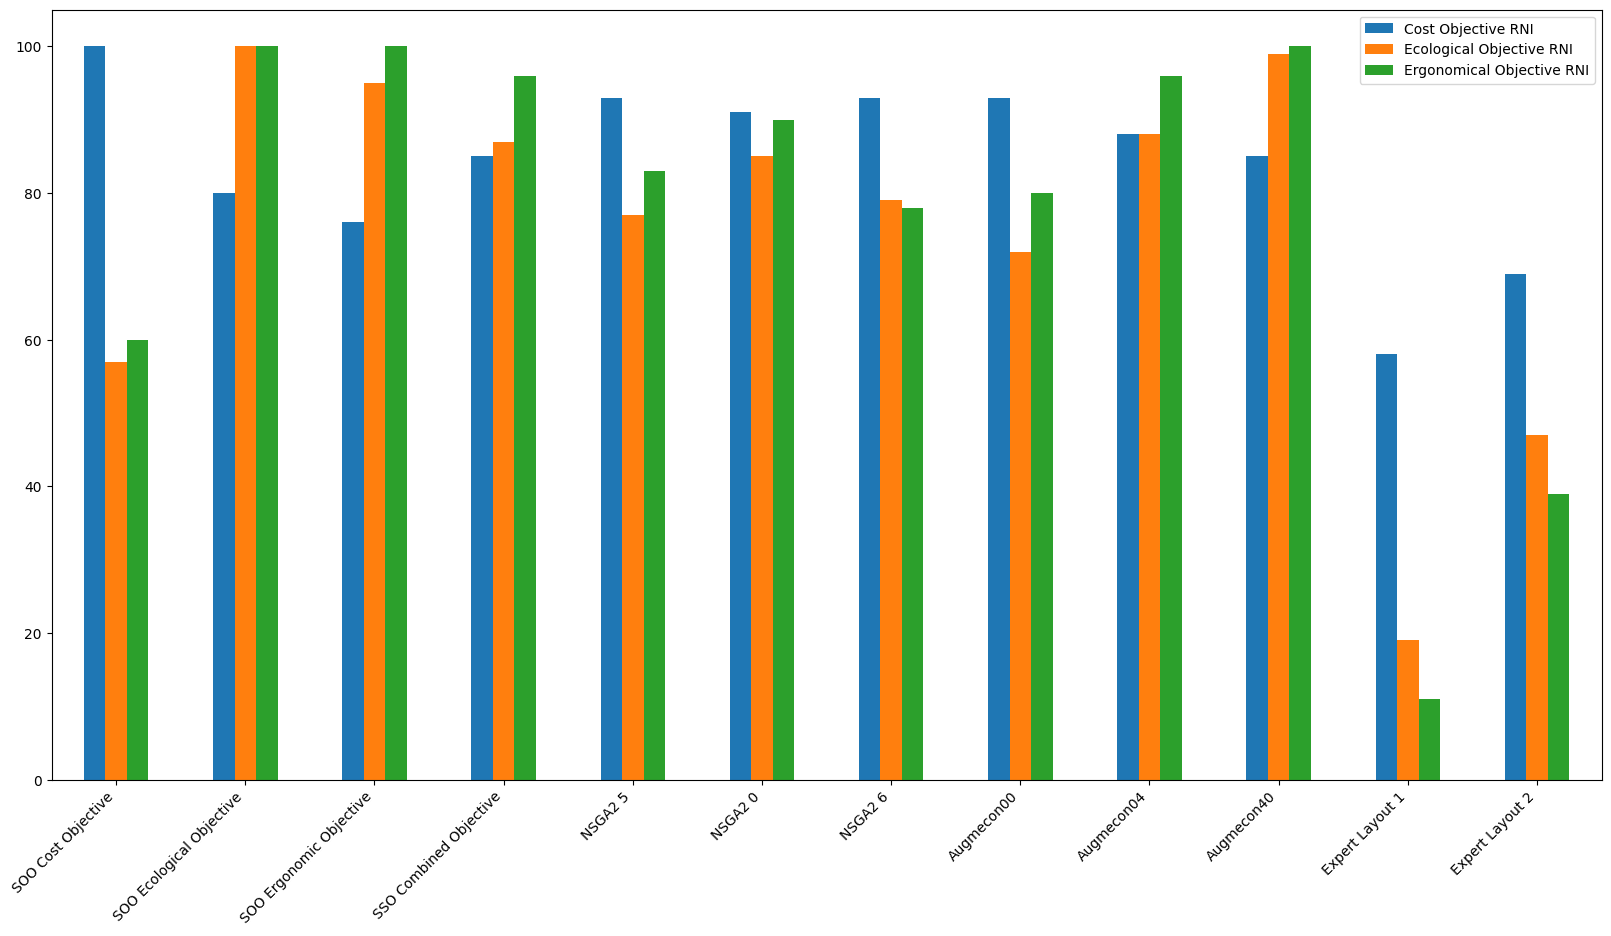

In [66]:
a = results_df.plot(kind="bar", figsize=(20, 10))
a.set_xticklabels(results_df["Model name"], rotation=45, ha="right")

In [75]:
pd.options.plotting.backend = "matplotlib"

/tmp/ipykernel_349845/2688942457.py:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(-2.0, 0, 'SOO Cost Objective'),
 Text(0.0, 0, 'SOO Ecological Objective'),
 Text(2.0, 0, 'SOO Ergonomic Objective'),
 Text(4.0, 0, 'SSO Combined Objective'),
 Text(6.0, 0, 'NSGA2 3'),
 Text(8.0, 0, 'NSGA2 0'),
 Text(10.0, 0, 'NSGA2 6'),
 Text(12.0, 0, 'Augmecon00')]

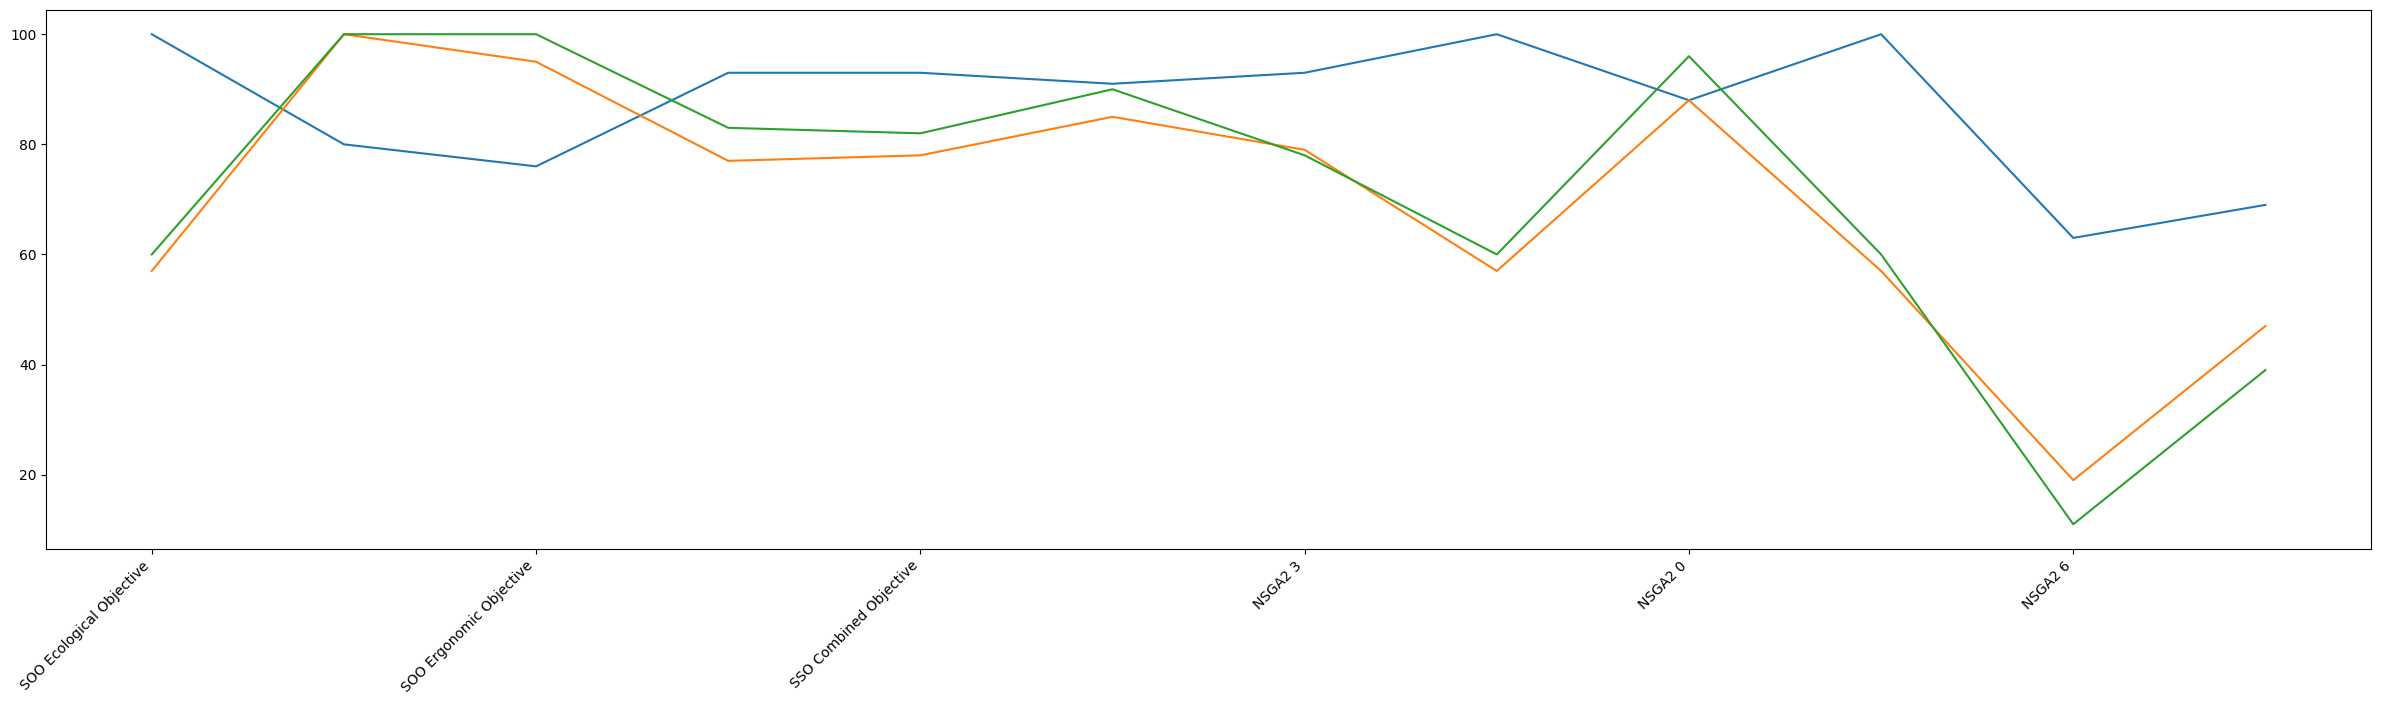

In [43]:
a = results_df[
    [
        "Cost Objective RNI",
        "Ecological Objective RNI",
        "Ergonomical Objective RNI",
    ]
].plot(
    # subplots=True,
    # layout=(1, 3),
    figsize=(30, 7),
    legend=False,
    # title=["Cost Objective RNI",
    #     "Ecological Objective RNI",
    #     "Ergonomical Objective RNI",],
)

a.set_xticklabels(results_df["Model name"], rotation=45, ha="right")

In [206]:
optimization_result_list

In [211]:
optimization_result_list

In [221]:
from src.main import plotting_2d

reload(plotting_2d)
for result in optimization_result_list:
    fig = plotting_2d.plot_optimization_layout(result, line_gdf, harvesteable_trees_gdf)
    fig.update_layout(showlegend=False, title=result.name)
    fig.show("notebook_connected")

In [21]:
import plotly.graph_objects as go
from ipywidgets import VBox

f = go.FigureWidget(
    go.Scatter3d(
        x=results_df["ecological_distances"],
        y=results_df["ergonomics_distances"],
        z=results_df["overall_profit"],
    )
)

f.update_layout(
    width=1200,
    height=800,
    title="Pareto Frontier",
    xaxis_title="Sideways slope deviations",
    yaxis_title="bad_ergonomics_distance",
    scene_zaxis_title="Overall profit",
)

t = go.FigureWidget([])


def selection_fn(trace, points, selector):
    # get index of this point in the trace
    index = points.point_inds[0]

    # update the layout plot to show this result
    t.data = []
    #
    t.add_traces(
        list(
            plotting_2d.plot_optimization_layout(
                optimization_result_list[index], line_gdf, harvesteable_trees_gdf
            ).data
        )
    )

    t.update_layout(title=optimization_result_list[index].name)


t.update_layout(width=1200, height=800)
f.data[0].on_click(selection_fn)
VBox((f, t))

    'data': [{'type': 'scatter3d',
              'uid': '7b54c03e-042d-406a-a064…

NameError: name 'plotting_2d' is not defined

NameError: name 'plotting_2d' is not defined

NameError: name 'plotting_2d' is not defined

#### Interactive CR Selection


In [23]:
import plotly.graph_objs as go
import plotly.offline as py

import pandas as pd
import numpy as np
from ipywidgets import VBox

from random import random

# create a trace for the trees
xs, ys = zip(*[(row.xy[0][0], row.xy[1][0]) for row in harvesteable_trees_gdf.geometry])
trees = go.Scatter(
    x=xs,
    y=ys,
    mode="markers",
    marker=dict(color="green"),
    name="trees",
)

# Create traces for each line
individual_lines = [
    go.Scatter(
        x=np.asarray(row.geometry.xy[0]) + random(),
        y=np.asarray(row.geometry.xy[1]) + random(),
        mode="lines",
        line=dict(color="lightgrey"),
        name=str(id),
    )
    for id, row in line_gdf.iterrows()
]

# create a figure from all individual scatter lines
f = go.FigureWidget([*individual_lines, trees])
f.update_layout(
    width=1000,
    height=800,
)


# create the onclick function to select new CRs
def selection_fn(trace, points, selector):
    # since the handler is activated for all lines, test if this one has coordinates, ie. is the clicked line
    if points.xs:
        if trace.line.color == "black":
            f.update_traces(line=dict(color="lightgrey"), selector={"name": trace.name})
        elif trace.line.color == "lightgrey":
            # update this trace to turn black
            f.update_traces(line=dict(color="black"), selector={"name": trace.name})

        # get all active traces
        active_traces = f.select_traces(selector={"line.color": "black"})
        active_traces_names = [int(trace.name) for trace in active_traces]

        # set the dataframe rows to show only these CRs
        t.data[0].cells.values = [df[df.index.isin(active_traces_names)]]
        # and update the dataframe showing the computed costs
        c.data[0].cells.values, test = update_layout_cost_df(active_traces_names)


# add the onclick function to all traces
for trace in f.data:
    trace.on_click(selection_fn)

# create a dataframe and push it to a figurewidget to display details about our selected lines
df = line_gdf[["line_cost", "line_length"]]
t = go.FigureWidget([go.Table(header=dict(values=df.columns), cells=dict(values=[df]))])

cost_gdf = pd.DataFrame(
    columns=["Tree_to_line_distance", "Productivity_cost", "Line_cost", "Profit"]
)
c = go.FigureWidget(
    [go.Table(header=dict(values=cost_gdf.columns), cells=dict(values=[cost_gdf]))]
)


def update_layout_cost_df(indices):
    rot_line_gdf = line_gdf[line_gdf.index.isin(indices)]

    # Create a matrix with the distance between every tree and line and the distance between the support (beginning of the CR) and the carriage (cloests point on the CR to the tree)
    (
        distance_tree_line,
        distance_carriage_support,
    ) = geometry_operations.compute_distances_facilities_clients(
        harvesteable_trees_gdf, rot_line_gdf
    )

    # assign all trees to their closest line
    try:
        tree_to_line_assignment = np.argmin(distance_tree_line, axis=1)

        # compute the distance of each tree to its assigned line
        distance_trees_to_lines = sum(
            distance_tree_line[
                range(len(tree_to_line_assignment)), tree_to_line_assignment
            ]
        )
    except:
        tree_to_line_assignment = [1 for i in range(len(distance_tree_line))]
        distance_trees_to_lines = sum(distance_tree_line)

    # compute the productivity cost
    productivity_cost_overall = np.sum(
        lscp_model_list[0].productivity_cost[
            range(len(tree_to_line_assignment)), tree_to_line_assignment
        ]
    )

    print(indices)
    line_cost = sum(rot_line_gdf["line_cost"])
    return [
        distance_trees_to_lines,
        productivity_cost_overall,
        line_cost,
        63025 - productivity_cost_overall,
        tree_to_line_assignment,
    ]


# Put everything together in a VBox
VBox((f, t, c))

    'data': [{'line': {'color': 'lightgrey'},
              'mode': 'lines',
   …

[]


ValueError: too many values to unpack (expected 2)

[]


ValueError: too many values to unpack (expected 2)

In [119]:
reload(plotting_2d)

## Computing cost of Christophs layout

selected_lines = [32, 59, 71]
a, b, c, d, e = update_layout_cost_df(selected_lines)

fac2cli = [[] for i in range(len(line_gdf))]
for index, val in enumerate(e):
    fac2cli[selected_lines[val]].append(index)

expert_df_1 = plotting_2d.expert_results_extraction(
    fac2cli,
    line_gdf,
    sample_model.aij,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
    sample_model.sideways_slope_deviations_per_cable_road,
    sample_model.ergonomic_penalty_lateral_distances,
    "expert_layout",
)

expert_df_1

[32, 59, 71]
Profit baseline is 62091.53735670836


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,5285.048891,4268.784147,45026.320343,62091.537357,1740.761392,0.0,expert_layout,396.377049,66704.044495


In [117]:
reload(plotting_2d)

## Computing cost of Christophs layout

selected_lines = [30, 37]
a, b, c, d, e = update_layout_cost_df(selected_lines)

fac2cli = [[] for i in range(len(line_gdf))]
for index, val in enumerate(e):
    fac2cli[selected_lines[val]].append(index)

expert_df_2 = plotting_2d.expert_results_extraction(
    fac2cli,
    line_gdf,
    sample_model.aij,
    distance_carriage_support,
    sample_model.productivity_cost,
    tree_volumes_list,
    sample_model.sideways_slope_deviations_per_cable_road,
    sample_model.ergonomic_penalty_lateral_distances,
    "expert_layout",
)

expert_df_2

[30, 37]
Profit baseline is 61938.02227946889


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,7927.307317,4422.299225,45421.926804,61938.022279,1160.394259,0.0,expert_layout,264.050473,38082.1076


In [120]:
expert_df = pd.concat([expert_df_1, expert_df_2])
expert_df

,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name,sideways_slope_deviations,bad_ergonomics_distance
0,5285.048891,4268.784147,45026.320343,62091.537357,1740.761392,0.0,expert_layout,396.377049,66704.044495
0,7927.307317,4422.299225,45421.926804,61938.022279,1160.394259,0.0,expert_layout,264.050473,38082.107600
